In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt
import math

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_ADNI, Decoder_ADNI, My_Dataset
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback
from lib.src.pythae.models.nn import BaseEncoder, BaseDecoder
from lib.src.pythae.models.base.base_utils import ModelOutput

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

%reload_ext autoreload
%autoreload 2
!nvidia-smi

Sun Sep 15 13:43:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   36C    P8             10W /   70W |     114MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
def extract_train_text(idx):
    visits = torch.load(f'ADNI_{idx}visits.pt')[:,:, 1:]

    train_idx = torch.randint(0, visits.shape[0], (int(visits.shape[0]*0.8),))
    val_idx = torch.randint(0, visits.shape[0], (int(visits.shape[0]*0.1),))
    test_idx = torch.randint(0, visits.shape[0], (int(visits.shape[0]*0.1),))

    train = visits[train_idx]
    val = visits[val_idx]
    test = visits[test_idx]
    return train, val, test

def fill_na(tensor, idx):
    tensor = torch.cat((tensor, float('nan')*torch.ones((tensor.shape[0], idx, tensor.shape[2]))), dim=1)
    return tensor

train_8, val_8, test_8 = extract_train_text(8)
train_7, val_7, test_7 = extract_train_text(7)
train_6, val_6, test_6 = extract_train_text(6)

train_7 = fill_na(train_7, 1)
train_6 = fill_na(train_6, 2)
eval_7 = fill_na(val_7, 1)
eval_6 = fill_na(val_6, 2)
test_7 = fill_na(test_7, 1)
test_6 = fill_na(test_6, 2)

train = torch.cat((train_8, train_7, train_6), dim=0)
eval = torch.cat((val_8, eval_7, eval_6), dim=0)
test = torch.cat((test_8, test_7, test_6), dim=0)

In [35]:
xxx = torch.load('ADNI_8visits.pt')
xxx[:10, :, 0]

tensor([[0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000],
        [0.0000, 0.5000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000]])

In [21]:
train_seq_mask = 1 - torch.isnan(train).float()[:, :, 0]
eval_seq_mask = 1 - torch.isnan(eval).float()[:, :, 0]
test_seq_mask = 1 - torch.isnan(test).float()[:, :, 0]

In [25]:
# Load the data
train_data = torch.load('ADNI_train.pt') #(N, T, D)
eval_data = torch.load('ADNI_eval.pt')
test_data = torch.load('ADNI_test.pt')
print(train_data.shape)

train_seq_mask = torch.load('ADNI_train_seq_mask.pt') #(N, T)
eval_seq_mask = torch.load('ADNI_eval_seq_mask.pt')
test_seq_mask = torch.load('ADNI_test_seq_mask.pt')


#Take only non-NaN values
train_data = train_data[train_seq_mask == 1]
eval_data = eval_data[eval_seq_mask == 1]
test_data = test_data[test_seq_mask == 1]
print(train_data.shape)

train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_Dataset(train_data)
eval_dataset = My_Dataset(eval_data)
test_dataset = My_Dataset(test_data)

torch.Size([8000, 8, 120])
torch.Size([56800, 120])


In [27]:
latent_dim = 9
input_dim = (1, 120)
encoder = Encoder_ADNI(input_dim, latent_dim)
decoder = Decoder_ADNI(input_dim, latent_dim)

model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=50,
learning_rate=5*1e-5,
per_device_train_batch_size=32,
per_device_eval_batch_size=64,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=25,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


In [ ]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="pre_training_VAE_latdim9_fulldataset", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    #callbacks=callbacks
)

In [18]:
#vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model/model.pt')["model_state_dict"])
_, mu, log_var = vae.retrieveG(train_data, verbose = True, T_multiplier=1, device = device)


# vae = vae.to('cuda')
# x = train_dataset[0:100]
# print(x.data.shape)
# x.data = x.data.unsqueeze(0).to('cuda')
# print(x.data.shape)

# out = vae(x)
# out['recon_x'].shape

Running Kmedoids
Finding temperature
Best temperature found:  0.0010893414728343487
Building metric
Increasing T by  1


In [19]:
n_samples = 100
batch_size = 100

all_z = []

device = 'cpu'
vae = vae.to(device)
mu = mu.to(device)


for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]
all_z = torch.cat(all_z, dim=0).cpu().detach()
all_z.shape

torch.Size([100, 12])

In [20]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
all_logdet_G = []
train_embeddings = []
device = 'cpu'
vae = vae.to(device)
for i, x in enumerate(train_loader):
    x = x.to(device)
    z = vae.encoder(x).embedding
    logdet_G = vae.log_pi(z)
    all_logdet_G.append(logdet_G)
    train_embeddings.append(z)

train_embeddings = torch.cat(train_embeddings, dim=0).cpu().detach()
print(train_embeddings.shape)
all_logdet_G = torch.cat(all_logdet_G).cpu().detach().numpy()
print(all_logdet_G.shape)


torch.Size([59000, 12])
(59000,)


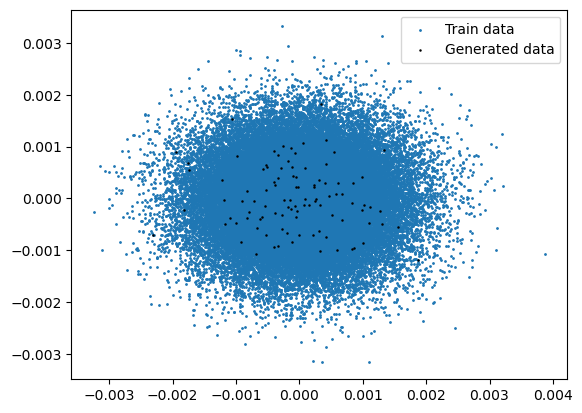

In [21]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS)
#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())

plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)

plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 0.6, label='Generated data', c = 'black')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


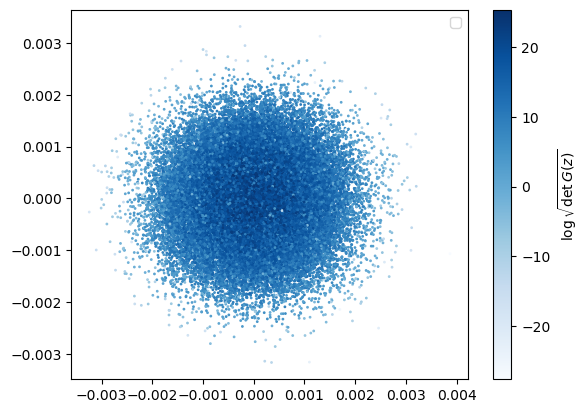

In [22]:
#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS)

#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=all_logdet_G, cmap='Blues', s=1)

plt.legend()
plt.colorbar(label=r'$ \log\sqrt{\det G(z)}$')
plt.show()